In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install transformers torch datasets --quiet

In [3]:
import pandas as pd
df = pd.read_csv('/content/UT-train.csv')
tdf = pd.read_csv('/content/UT-test.csv')
df

,text,source,category,class
0,মাগির পোলা তর ভাব দেখতে ভালো লাগে না। তোমার বি...,toxic_comments,Unsafe,Adult
1,বি এনপি একটি অনুভূতির নাম।।,bangla_comment_dataset,Safe,Safe
2,The Talking Bro,Facebook,Safe,Safe
3,আহরে রোজার দিনের রোগে দরে পাবনা হসপিটাল কি বন্...,bangla_comment_dataset,Safe,Safe
4,বড় বড় লোকের বড় বড় ব্যাপার- স্যাপার,bangla_comment_dataset,Safe,Safe
...,...,...,...,...
7755,বান্দির পুতে এমনে ফাল পারে কেন﻿,toxic_comments,Unsafe,Adult
7756,ইতিহাসের প্রথমবারের মতো কম্বলের নিচে গিটার বা...,Facebook,Safe,Safe
7757,"ওয়াল্টন আর মার্সেল কি দোষ করছে যে,শেষ পর্যন্ত ...",toxic_comments,Unsafe,Adult
7758,নাইস বোগল,bangla_comment_dataset,Safe,Safe


In [4]:
df['category'].value_counts()

,count
category,
Safe,4377
Unsafe,3383


In [5]:
df['class'].value_counts()

,count
class,
Safe,4377
Adult,1434
Harmful,1100
Suicidal,849


In [6]:
tdf['category'].value_counts()

,count
category,
Safe,285
Unsafe,220


In [7]:
tdf['class'].value_counts()

,count
class,
Safe,285
Adult,93
Harmful,72
Suicidal,55


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
categories = ['Safe', 'Unsafe']
df['category'] = pd.Categorical(df['category'], categories=categories, ordered=True)
df['category'], uniques = pd.factorize(df['category'], sort=True)
uniques

CategoricalIndex(['Safe', 'Unsafe'], categories=['Safe', 'Unsafe'], ordered=True, dtype='category')

In [10]:
tdf['category'] = pd.Categorical(tdf['category'], categories=categories, ordered=True)
tdf['category'], tuniques = pd.factorize(tdf['category'], sort=True)
tuniques

CategoricalIndex(['Safe', 'Unsafe'], categories=['Safe', 'Unsafe'], ordered=True, dtype='category')

In [11]:
# df['class'], cuniques = pd.factorize(df['class'])
# cuniques

In [12]:
df

,text,source,category,class
0,মাগির পোলা তর ভাব দেখতে ভালো লাগে না। তোমার বি...,toxic_comments,1,Adult
1,বি এনপি একটি অনুভূতির নাম।।,bangla_comment_dataset,0,Safe
2,The Talking Bro,Facebook,0,Safe
3,আহরে রোজার দিনের রোগে দরে পাবনা হসপিটাল কি বন্...,bangla_comment_dataset,0,Safe
4,বড় বড় লোকের বড় বড় ব্যাপার- স্যাপার,bangla_comment_dataset,0,Safe
...,...,...,...,...
7755,বান্দির পুতে এমনে ফাল পারে কেন﻿,toxic_comments,1,Adult
7756,ইতিহাসের প্রথমবারের মতো কম্বলের নিচে গিটার বা...,Facebook,0,Safe
7757,"ওয়াল্টন আর মার্সেল কি দোষ করছে যে,শেষ পর্যন্ত ...",toxic_comments,1,Adult
7758,নাইস বোগল,bangla_comment_dataset,0,Safe


In [13]:
# df = df.sample(frac=1).reset_index(drop=True)
# df

In [14]:
X = df['text']
y = df['category']

train_texts, val_texts, train_labels, val_labels = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y)

In [15]:
test_texts = tdf['text']
test_labels = tdf['category']

In [16]:
from transformers import AutoTokenizer

# Load the tokenizer (you can use 'bert-base-multilingual-cased', 'xlm-roberta-base', or 'csebuetnlp/banglabert')
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [17]:
import torch
from datasets import Dataset

# Convert data into Hugging Face Dataset format
train_data = Dataset.from_dict({"text": train_texts.tolist(), "label": train_labels.tolist()})
val_data = Dataset.from_dict({"text": val_texts.tolist(), "label": val_labels.tolist()})
test_data = Dataset.from_dict({"text": test_texts.tolist(), "label": test_labels.tolist()})

In [18]:
def preprocess_function(examples):
    return tokenizer(
        examples['text'],
        padding=True,
        truncation=True,
        max_length=512,
)

In [19]:
train_data = train_data.map(preprocess_function, batched=True)
val_data = val_data.map(preprocess_function, batched=True)
test_data = test_data.map(preprocess_function, batched=True)

Map:   0%|          | 0/6984 [00:00<?, ? examples/s]

Map:   0%|          | 0/776 [00:00<?, ? examples/s]

Map:   0%|          | 0/505 [00:00<?, ? examples/s]

In [20]:
train_data

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 6984
})

In [21]:
train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [22]:
from transformers import AutoModel

model = AutoModel.from_pretrained(model_name)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [23]:
import torch
import torch.nn as nn
from transformers import AutoModel

class BERT_LSTM(nn.Module):
    def __init__(self, lstm_hidden_size=256, lstm_layers=1, dropout=0.3):
        super(BERT_LSTM, self).__init__()

        # ✅ Load BERT inside the class
        self.bert = model

        # ✅ LSTM Layer (Bidirectional)
        self.lstm = nn.LSTM(input_size=768, hidden_size=lstm_hidden_size, num_layers=lstm_layers,
                            batch_first=True, bidirectional=True, dropout=dropout)

        # ✅ Fully connected classification layer
        self.fc = nn.Linear(lstm_hidden_size * 2, 1)  # ⬅ Single output for binary classification

        # ✅ Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

        # ✅ Use Binary Cross Entropy Loss
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        # Get embeddings from BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)

        hidden_states = outputs.last_hidden_state  # (batch_size, seq_len, 768)

        # Pass through BiLSTM
        lstm_out, _ = self.lstm(hidden_states)  # (batch_size, seq_len, hidden_size*2)
        lstm_out = lstm_out[:, -1, :]  # Take the last time step output

        # Pass through the classifier
        logits = self.fc(self.dropout(lstm_out))  # (batch_size, 1)

        # Compute loss if labels are provided
        loss = None
        if labels is not None:
            labels = labels.float().unsqueeze(1)  # ✅ Ensure correct shape
            loss = self.criterion(logits, labels)

        return (loss, logits) if loss is not None else logits

In [24]:
model = BERT_LSTM()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [25]:
from transformers import TrainingArguments, EarlyStoppingCallback

In [26]:
training_args = TrainingArguments(
    output_dir="./mbert_lstm",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    logging_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.005,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [27]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # ✅ Apply Sigmoid since BCEWithLogitsLoss does not include it
    probs = torch.sigmoid(torch.tensor(logits))

    # ✅ Convert probabilities to binary predictions (0 or 1)
    predictions = (probs > 0.5).int().numpy()

    # ✅ Compute metrics for binary classification
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="binary", zero_division=1
    )

    acc = accuracy_score(labels, predictions)

    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [28]:
def make_model_contiguous(model):
    for param in model.parameters():
        param.data = param.data.contiguous()  # ✅ Ensure tensor is contiguous
        if param.grad is not None:
            param.grad.data = param.grad.data.contiguous()

make_model_contiguous(model)

In [29]:
from transformers import Trainer

trainer = Trainer(
    model=model,                         # Pretrained model
    args=training_args,                  # Updated training arguments
    train_dataset=train_data,            # Training data
    eval_dataset=val_data,               # Validation data
    tokenizer=tokenizer,                 # Tokenizer
    compute_metrics=compute_metrics,      # Updated metrics function
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

<ipython-input-29-0337d9dab4b2>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arefinlabibndc19 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.533800,0.426032,0.783505,0.821970,0.642012,0.720930
2,0.408900,0.401641,0.819588,0.809375,0.766272,0.787234
3,0.346600,0.446267,0.822165,0.804878,0.781065,0.792793
4,0.301900,0.550788,0.827320,0.798246,0.807692,0.802941
5,0.259500,0.597146,0.826031,0.802985,0.795858,0.799406


TrainOutput(global_step=4365, training_loss=0.37015684986442227, metrics={'train_runtime': 4036.378, 'train_samples_per_second': 8.651, 'train_steps_per_second': 1.081, 'total_flos': 0.0, 'train_loss': 0.37015684986442227, 'epoch': 5.0})

In [30]:
import numpy as np
from sklearn.metrics import classification_report
import torch

# Get predictions from the trainer
predictions = trainer.predict(test_data)

# ✅ Convert logits to probabilities using sigmoid
probs = torch.sigmoid(torch.tensor(predictions.predictions))

# ✅ Convert probabilities to binary labels (threshold = 0.5)
predicted_labels = (probs > 0.5).int().numpy()

# ✅ Print classification report for binary classification
print(classification_report(test_labels, predicted_labels, digits=4))

              precision    recall  f1-score   support

           0     0.8375    0.8140    0.8256       285
           1     0.7675    0.7955    0.7812       220

    accuracy                         0.8059       505
   macro avg     0.8025    0.8047    0.8034       505
weighted avg     0.8070    0.8059    0.8063       505



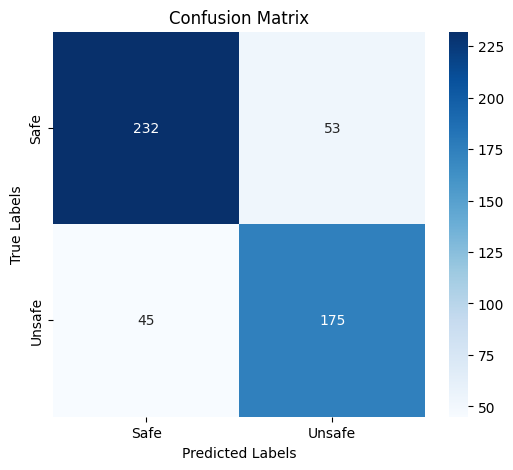

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=uniques, yticklabels=uniques)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [32]:
# Save the full model, not just the transformer
torch.save(model.state_dict(), "/content/drive/MyDrive/SafeReels-664/Models/Text_models/mBERT-LSTM.pth")